In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, InceptionResNetV2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers, preprocessing, optimizers

import optuna
# from optuna.integration import KerasPruner

In [2]:
labels = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 128

for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=14)
print(X_train.shape)
print(X_test.shape)


100%|██████████| 74/74 [00:01<00:00, 73.68it/s]


(2870, 128, 128, 3)
(394, 128, 128, 3)


In [3]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

x_train, y_train = shuffle(X_train,y_train, random_state=11)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train, test_size=0.1,random_state=14)
x_train = np.array(x_train) / 255.
x_val = np.array(x_val) / 255.
x_test = np.array(X_test) / 255.


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [4]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 2, 5)
    layers_list = []
    layers_list.append(layers.Input((image_size, image_size, 3)))
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    for i in range(n_layers):
        filter = trial.suggest_int("filter_{}".format(i), 5, 8)
        layers_list.append(layers.Conv2D(2**filter, (3, 3), activation="relu", padding="same"))
        layers_list.append(layers.MaxPooling2D(2, 2))
        layers_list.append(layers.Dropout(dropout))
        
    layers_list.append(layers.Flatten())
    layers_list.append(layers.Dense(128, activation="linear"))
    layers_list.append(layers.Dropout(0.5))
    layers_list.append(layers.Dense(4, activation="softmax"))

    return keras.Sequential(layers_list)

def objective(trial):
    # Создание модели
    model = define_model(trial)
    
    # Компиляция модели
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # pruning_callback = KerasPruningCallback(trial, 'val_accuracy')
    
    history = model.fit(x_train[:500], y_train[:500],
                        # validation_data=(x_test, y_test),
                        shuffle=True,
                        epochs=5,
                        batch_size=32,
                        validation_split=0.1,
                        # callbacks=[pruning_callback]
                       )

    # Возвращаем значение метрики для оптимизации (например, валидируемую точность)
    return max(history.history['val_accuracy'])


In [5]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, timeout=7000, show_progress_bar=True)

[I 2024-10-10 01:51:57,076] A new study created in memory with name: no-name-760d80ab-8a64-41ea-b683-fe778378dd2a


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/5
15/15 [==============================] - 43s 3s/step - loss: 1.7105 - accuracy: 0.3511 - val_loss: 1.3095 - val_accuracy: 0.2600
Epoch 2/5
15/15 [==============================] - 40s 3s/step - loss: 1.1941 - accuracy: 0.4756 - val_loss: 1.1331 - val_accuracy: 0.4600
Epoch 3/5
15/15 [==============================] - 40s 3s/step - loss: 1.1021 - accuracy: 0.5333 - val_loss: 0.9563 - val_accuracy: 0.5800
Epoch 4/5
15/15 [==============================] - 40s 3s/step - loss: 0.9717 - accuracy: 0.5822 - val_loss: 0.8291 - val_accuracy: 0.7400
Epoch 5/5
15/15 [==============================] - 42s 3s/step - loss: 0.8152 - accuracy: 0.6644 - val_loss: 0.7592 - val_accuracy: 0.7000
[I 2024-10-10 01:55:23,115] Trial 0 finished with value: 0.7400000095367432 and parameters: {'n_layers': 2, 'dropout': 0.23406462855246118, 'filter_0': 8, 'filter_1': 6}. Best is trial 0 with value: 0.7400000095367432.
Epoch 1/5
15/15 [==============================] - 42s 3s/step - loss: 1.9629 - accura

In [6]:
params_dict = {'n_layers': 3, 'dropout': 0.2239859792220779, 'filter_0': 6, 'filter_1': 7, 'filter_2': 5}

frozen_trial = optuna.trial.FrozenTrial(
    trial_id=3,
    state=optuna.trial.TrialState.COMPLETE,  
    number=3,
    value=0.8199999928474426,
    params=params_dict,
    distributions={
        'n_layers': optuna.distributions.IntDistribution(2, 5),
        'dropout': optuna.distributions.FloatDistribution(0.2, 0.5),
        'filter_0': optuna.distributions.IntDistribution(5, 8),
        'filter_1': optuna.distributions.IntDistribution(5, 8),
        'filter_2': optuna.distributions.IntDistribution(5, 8),
    },
    user_attrs={},
    system_attrs={},
    datetime_start=None,
    datetime_complete=None,
    intermediate_values={},
)

In [7]:
best_model = define_model(study.best_trial)
# best_model = define_model(frozen_trial)

best_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = best_model.fit(x_train, y_train,
                validation_data=(x_test, y_test),
                epochs=10,
                batch_size=32,
                shuffle=True)

# Сохранение лучшей модели в файл
best_model.save("brain_tumor_model.h5")

print("Best trial parameters: ", study.best_trial.params)
print("Best trial accuracy: ", study.best_trial.value)
# print("Best trial parameters: ", frozen_trial)
# print("Best trial accuracy: ", frozen_trial)

Epoch 1/10
81/81 [==============================] - 234s 3s/step - loss: 1.1986 - accuracy: 0.5122 - val_loss: 2.1440 - val_accuracy: 0.3782
Epoch 2/10
81/81 [==============================] - 232s 3s/step - loss: 0.6719 - accuracy: 0.7267 - val_loss: 2.0598 - val_accuracy: 0.5152
Epoch 3/10
81/81 [==============================] - 233s 3s/step - loss: 0.4885 - accuracy: 0.8188 - val_loss: 2.3074 - val_accuracy: 0.5609
Epoch 4/10
81/81 [==============================] - 233s 3s/step - loss: 0.3748 - accuracy: 0.8571 - val_loss: 2.7673 - val_accuracy: 0.6142
Epoch 5/10
81/81 [==============================] - 233s 3s/step - loss: 0.3123 - accuracy: 0.8761 - val_loss: 2.2674 - val_accuracy: 0.6497
Epoch 6/10
81/81 [==============================] - 234s 3s/step - loss: 0.2708 - accuracy: 0.9021 - val_loss: 2.8908 - val_accuracy: 0.6548
Epoch 7/10
81/81 [==============================] - 233s 3s/step - loss: 0.2665 - accuracy: 0.9040 - val_loss: 2.6345 - val_accuracy: 0.6802
Epoch 8/10
81

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
best_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 128, 128, 256)     7168      
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 64, 64, 256)       0         
 ng2D)                                                           
                                                                 
 dropout_80 (Dropout)        (None, 64, 64, 256)       0         
                                                                 
 conv2d_61 (Conv2D)          (None, 64, 64, 64)        147520    
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_81 (Dropout)        (None, 32, 32, 64)      

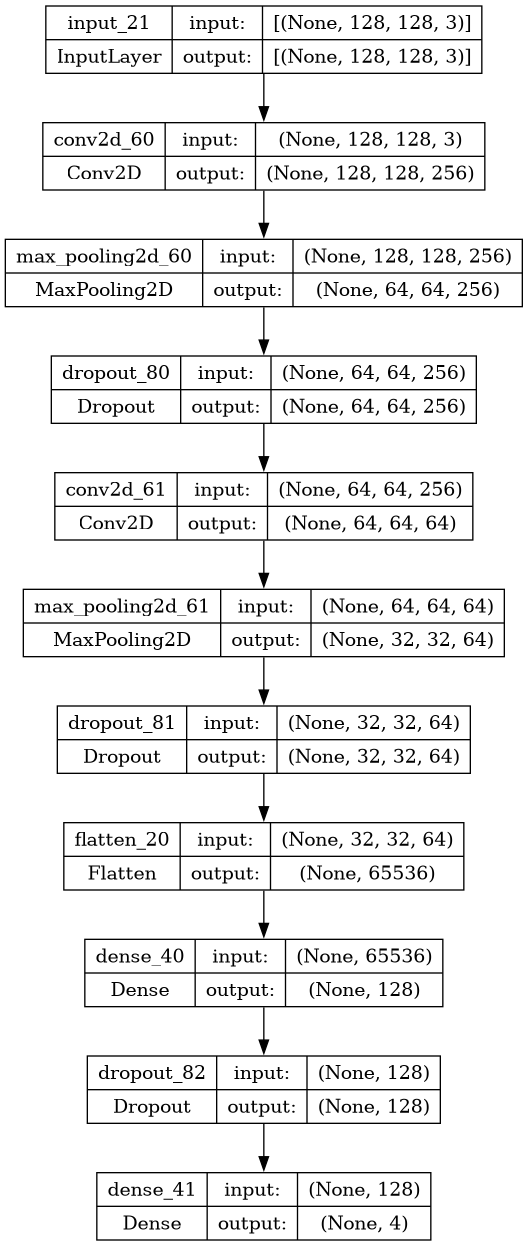

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(best_model, to_file='brain_tumor_model.png', show_shapes=True)

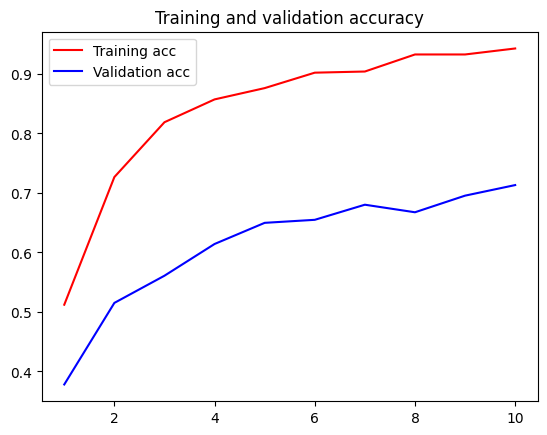

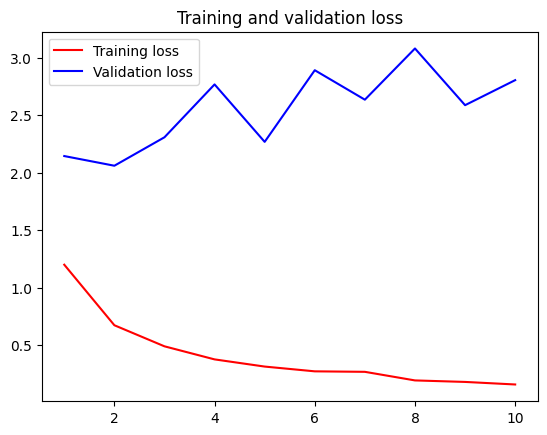

In [12]:
# model.save('cnn_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
pred = best_model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

print(classification_report(y_test_new,pred))


13/13 [==============================] - 10s 700ms/step
Accuracy on testing dataset: 71.32%
              precision    recall  f1-score   support

           0       0.71      0.92      0.80       105
           1       0.78      0.21      0.33       100
           2       0.67      0.93      0.78       115
           3       0.80      0.76      0.78        74

    accuracy                           0.71       394
   macro avg       0.74      0.71      0.67       394
weighted avg       0.73      0.71      0.67       394



1/1 [==============================] - 0s 43ms/step
Probabilities for each class:
no_tumor: 0.7230
glioma_tumor: 0.0000
meningioma_tumor: 0.2770
pituitary_tumor: 0.0000
Image array shape after expanding: (1, 128, 128, 3)


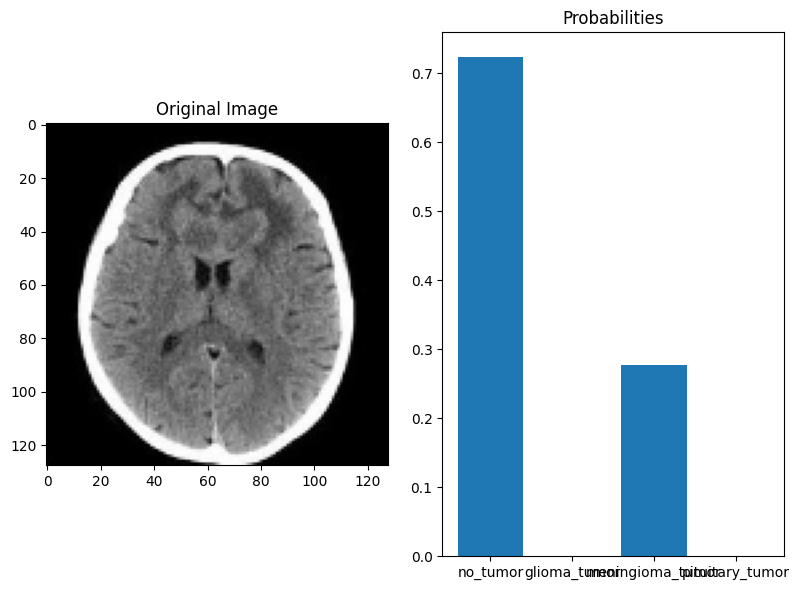

[1. 0. 0. 0.]


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model

# Функция для отображения изображения и вероятностей
def display_results(model, img, class_names):
    img_array = np.expand_dims(img, axis=0) 
    # Получение предсказаний
    preds = model.predict(img_array)
    
    # Вероятности принадлежности к классам
    probabilities = preds[0]
    
    # Вывод вероятностей
    print("Probabilities for each class:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {probabilities[i]:.4f}")

    print(f"Image array shape after expanding: {img_array.shape}")  # Should be (1, 128, 128, 3)

    # Apply color map
    
    # Now we can blend with img_array

    # Визуализация результатов
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img_array[0])
    
    plt.subplot(1, 3, 2)
    plt.title('Probabilities')
    plt.bar(class_names, probabilities)
    
    # plt.subplot(1, 3, 3)
    # plt.title('Grad-CAM')
    # plt.imshow(superimposed_img)

    plt.tight_layout()
    plt.show()

# Пример использования:
# Предположим у вас есть обученная модель `model` и изображение `img_array`

# Вывод результатов
display_results(best_model, x_test[1], labels)
print(y_test[1])

1/1 [==============================] - 0s 47ms/step


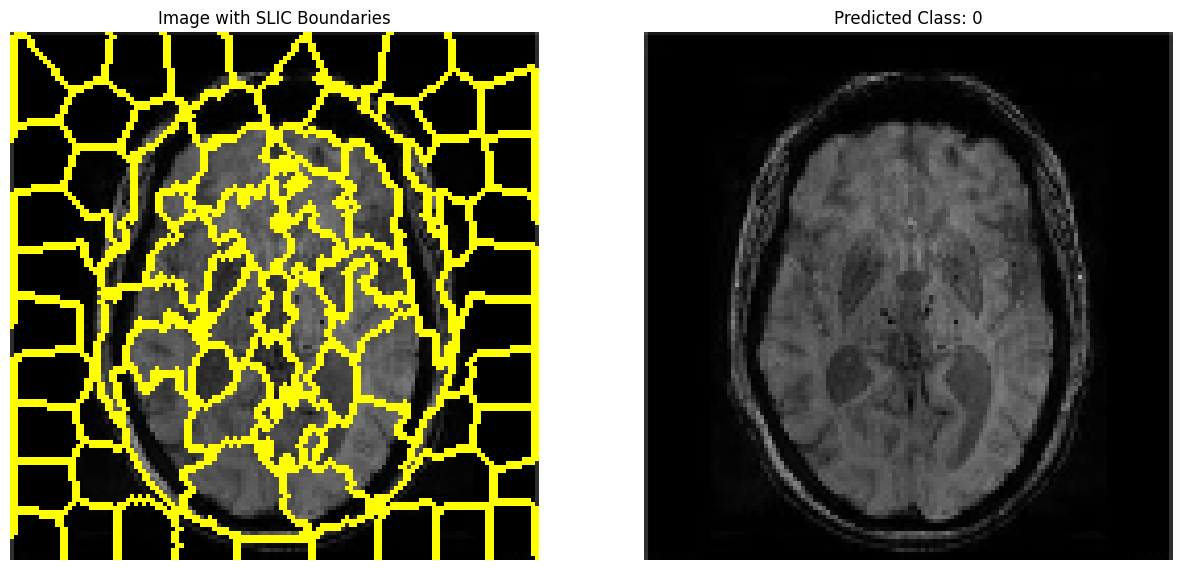

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries

# Load your trained model
# best_model = tf.keras.models.load_model('path_to_your_model.h5')

# Prepare your image as a NumPy array (replace this with your actual image array)
# Example: Create a random RGB image for demonstration
image = x_test[2]  # Random image for illustration
# image = image.astype(np.uint8)  # Convert to uint8

# # Normalize and preprocess your image for prediction if needed
# image_resized = tf.image.resize(image, (128, 128))  # Resize if needed
image_resized = np.expand_dims(image, axis=0)  # Add batch dimension

# Make a prediction using your model
class_index = 1  # Replace with the desired class index for prediction
predictions = best_model.predict(image_resized)
predicted_class = np.argmax(predictions, axis=1)

# Apply SLIC segmentation on the original image
segments = slic(image, n_segments=100, compactness=10)

# Mark
marked_image = mark_boundaries(image, segments)

# Plotting the results
plt.figure(figsize=(15, 7))

# Original Image with Marked Boundaries
plt.subplot(1, 2, 1)
plt.imshow(marked_image)
plt.title('Image with SLIC Boundaries')
plt.axis('off')

# Display Prediction Result
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class[0]}')
plt.axis('off')

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 243ms/step


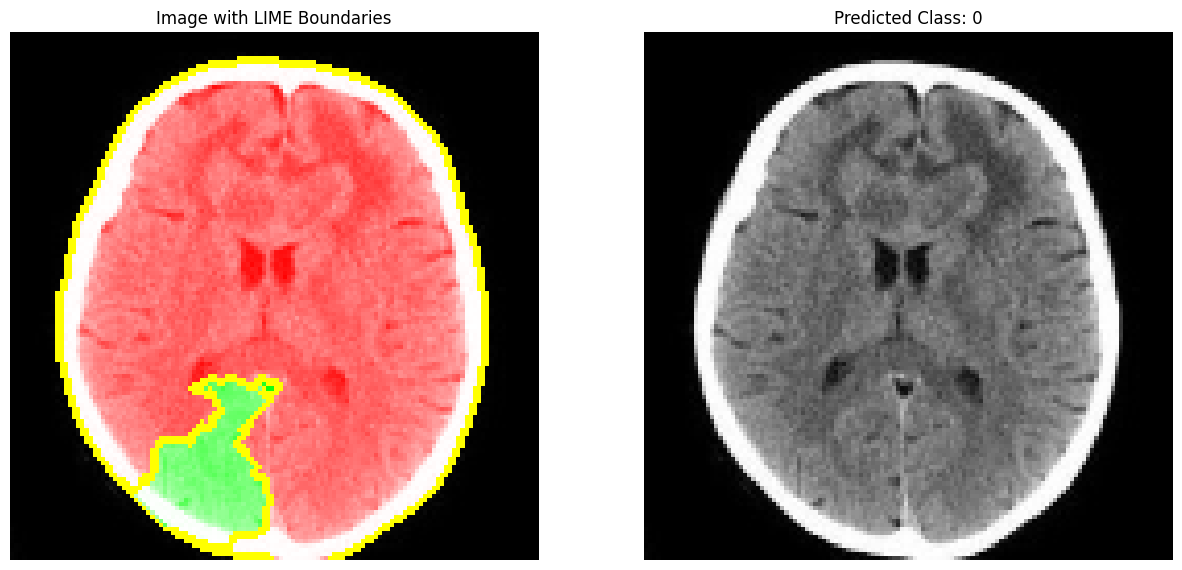

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries

image = x_test[1]  # Random image for illustration
image_resized = np.expand_dims(image, axis=0)  # Add batch dimension

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image_resized[0], best_model.predict, top_labels=2, hide_color=0, num_samples=1000)
source_image, mask = explanation.get_image_and_mask(0, positive_only=False)

marked_image = mark_boundaries(source_image, mask)

# Plotting the results
plt.figure(figsize=(15, 7))

# Original Image with Marked Boundaries from LIME
plt.subplot(1, 2, 1)
plt.imshow(marked_image)
plt.title('Image with LIME Boundaries')
plt.axis('off')

# Display Prediction Result
plt.subplot(1, 2, 2)
plt.imshow(image)  # Normalize for display if needed
plt.title(f'Predicted Class: {predicted_class[0]}')
plt.axis('off')

plt.show()